In [4]:
%matplotlib widget

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

In [7]:
scene = "airplane1"
out_ckpt_dir = "./plots"
new_dir = f"{out_ckpt_dir}/{scene}"
if not os.path.exists(new_dir):
    os.mkdir(new_dir)


In [8]:
suffix = "all_100"
ckpt_dir = "/home/ccl/Code/svox2/opt/ckpt_auto/scannerf_light_short"

base_dir = f"{ckpt_dir}/{suffix}/{scene}/test_renders"
c2ws = np.load(f"{base_dir}/c2ws.npy")


c2ws = np.load(f"{base_dir}/c2ws.npy")

# center_pt = np.mean(c2ws[:,:3,3], axis=0)
center_pt = np.zeros(3)

# directions_train = (c2ws_train[:,:3,3] - center_pt)
directions = (c2ws[:,:3,3] - center_pt)
# directions_train = directions_train / np.linalg.norm(directions_train, keepdims=True, axis=1)
directions = directions / np.linalg.norm(directions, keepdims=True, axis=1)
# cos_dist = np.matmul(directions, directions_train.transpose())
# closest_train_index = np.argmax(cos_dist, axis=1)
# cos_dist = np.max(cos_dist, axis=1)
# angles = np.arccos(cos_dist)
abs_angles = np.arctan2(directions[:,0], directions[:,2])

def get_metrics(base_dir, base_train):
    psnr = np.load(f"{base_dir}/psnr.npy")
    psnr_train = np.load(f"{base_train}/psnr.npy")
    return psnr, psnr_train
    
# suffixes = ["all_100", "all_250", "all_500", "all"]
suffixes = ["all_100","all"]
c2ws_train = []
psnrs = []
psnrs_train = []

for suffix in suffixes:
    base_dir2 = f"{ckpt_dir}/{suffix}/{scene}/test_renders"
    base_dir2_train = f"{ckpt_dir}/{suffix}/{scene}/train_renders"

    c2ws_train.append(np.load(f"{base_dir2_train}/c2ws.npy"))
    psnr, psnr_train = get_metrics(base_dir2, base_dir2_train)
    psnrs.append(psnr)
    psnrs_train.append(psnr_train)

psnrs = np.stack(psnrs)
# psnrs_train = np.stack(psnrs_train)
best_psnr = np.max(psnrs, axis=0)
best_psnr_idx = np.argmax(psnrs, axis=0)

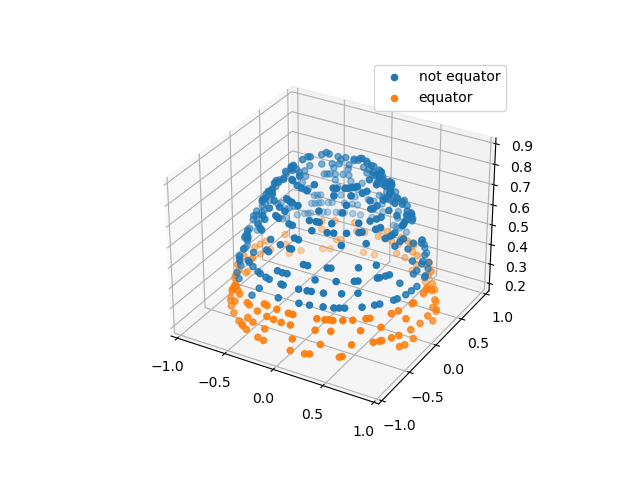

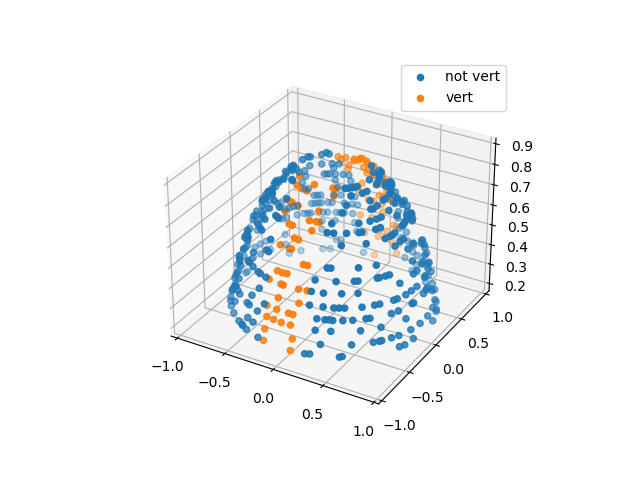

In [9]:

def xyz(c2ws):
    return c2ws[:,0,3], c2ws[:,2,3], -c2ws[:,1,3]

def plot_filter(condition, labels, filename):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    inlier = np.where(condition)
    outlier = np.where(np.logical_not(condition))
    ax.scatter(*xyz(c2ws[outlier]), label=labels[1])
    ax.scatter(*xyz(c2ws[inlier]), label=labels[0])
    ax.legend()
    fig.savefig(f"{out_ckpt_dir}/{scene}/{filename}")
    

    psnr_filtered = psnrs[:,inlier][:,0,:]
    c2ws_filtered = c2ws[inlier]
    abs_angles_filtered = abs_angles[inlier]
    return inlier, psnr_filtered, c2ws_filtered, abs_angles_filtered


# equator
equator_threshold = -0.4  

equator, psnrs_equator, c2ws_equator, abs_angles_equator = plot_filter(c2ws[:,1,3] > equator_threshold, ["equator", "not equator"], "equator_selection.jpeg")
vert, psnrs_vert, c2ws_vert, abs_angles_vert = plot_filter(np.abs(c2ws[:,0,3]) < 0.2, ["vert", "not vert"], "vert_selection.jpeg")


In [ ]:

fig = plt.figure()
ax = fig.add_subplot(projection='polar')
plt.ylabel("PSNR")
plt.xlabel("absolute angle around scene center")
plt.title(f"Scene: {scene} - PSNR at equator")
x = abs_angles_equator
for i, suffix in enumerate(suffixes):
    y = psnrs_equator[i]
    idx = np.argsort(x)
    # ax.plot(x[idx], y[0,idx], label=f"{suffix}")
    ax.scatter(x, y, label=f"{suffix}")

ax.legend()
fig.savefig(f"{out_ckpt_dir}/{scene}/{scene}_psnr_equator.jpeg")


In [ ]:
fail_idx = np.argsort(psnrs_equator, axis=1)[:,:8]
success_idx = np.argsort(psnrs_equator, axis=1)[:,-8:]

In [ ]:
def vis_sample(img_id, desc):
    fig = plt.figure(figsize=(10,8))
    ax1 = plt.subplot(211, projection='polar')
    ax2 = plt.subplot(212)
    
    ax1.title.set_text(f"{desc} - img_id {img_id}")
    for j, suffix in enumerate(suffixes):
        ax1.scatter(abs_angles_equator, psnrs_equator[j], s=5, label=suffix)
    ax1.scatter([abs_angles[img_id]], psnrs[0,img_id], s=100, label=f"current")
    
    
    img_path = os.path.join(base_dir, f'{img_id:04d}.png')
    img = np.asarray(Image.open(img_path))
    ax2.title.set_text(f"{desc} - PSNR: {psnrs[0,img_id]:.2f}")
    ax2.imshow(img)
    
    fig.savefig(f"{out_ckpt_dir}/{scene}/{scene}_{desc}_{psnrs[0,img_id]:.03f}_{img_id}.png")
    


In [ ]:

for img_id in list(equator[0][fail_idx][0,:]):
    vis_sample(img_id, "failure_case")

In [ ]:

for img_id in list(equator[0][success_idx][0,:]):
    vis_sample(img_id, "success_case")
    

In [ ]:

fig = plt.figure(figsize=(10,8))
plt.title("locations of different training/validation samples")
ax = fig.add_subplot(projection='3d')

ax.scatter(c2ws[:,0,3],c2ws[:,2,3],-c2ws[:,1,3], s=5, label="val_all")
for i, suffix in enumerate(suffixes):
    # plt.title(f"train locations {suffix}")
    ax.scatter(c2ws_train[i][:,0,3],c2ws_train[i][:,2,3],-c2ws_train[i][:,1,3], s=5, label=f"train_{suffix}")

ax.legend()
fig.savefig(f"new_dir/{scene}/{scene}_sample_locations.jpeg")